In [2]:
!pip install boto3

In [7]:
!pip install torch torchvision faiss-cpu pillow numpy

In [4]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
from concurrent.futures import ThreadPoolExecutor

# Setup (Same as before)
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED), region_name="us-east-1")
bucket = "aft-vbi-pds"
img_prefix = "bin-images/"
meta_prefix = "metadata/"

os.makedirs("bin-images", exist_ok=True)
os.makedirs("metadata", exist_ok=True)

# 1. Fetch list of keys first (Fast)
print("Fetching file list...")
response = s3.list_objects_v2(Bucket=bucket, Prefix=img_prefix, MaxKeys=1200)
keys_to_download = []

for obj in response.get("Contents", []):
    key = obj["Key"]
    filename = key.split("/")[-1]
    if filename.endswith(".jpg"):
        keys_to_download.append(filename)
    if len(keys_to_download) >= 1000:
        break

# 2. Define a function to download a SINGLE pair
def download_pair(filename):
    try:
        # Download Image
        s3.download_file(bucket, f"{img_prefix}{filename}", f"bin-images/{filename}")
        
        # Download Metadata
        json_filename = filename.replace(".jpg", ".json")
        s3.download_file(bucket, f"{meta_prefix}{json_filename}", f"metadata/{json_filename}")
        return True
    except Exception as e:
        return False

# 3. Run in Parallel (The Speed Boost)
print(f"Starting download of {len(keys_to_download)} pairs...")

# max_workers=20 means 20 downloads happen at once
with ThreadPoolExecutor(max_workers=20) as executor:
    results = list(executor.map(download_pair, keys_to_download))

print(f"✅ Download complete! Successfully downloaded {sum(results)} pairs.")

Fetching file list...
Starting download of 999 pairs...
✅ Download complete! Successfully downloaded 999 pairs.


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import faiss
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt

class BinSearchSystem:
    def __init__(self, image_folder, metadata_folder):
        self.image_folder = image_folder
        self.metadata_folder = metadata_folder
        self.image_paths = [] 
        
        # Load AI Model (ResNet18)
        print("Loading AI Model...")
        # Use default weights
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model = nn.Sequential(*list(self.model.children())[:-1]) # Remove last layer
        self.model.eval()

        # Preprocessing settings
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Initialize Search Index
        self.index = faiss.IndexFlatL2(512) 

    def get_embedding(self, img_path):
        """Converts an image file into a vector."""
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.preprocess(img).unsqueeze(0)
        with torch.no_grad():
            vector = self.model(img_tensor)
        return vector.numpy().reshape(1, -1)

    def build_index(self):
        """Indexes all images in the folder."""
        print("Building Index (this might take a minute)...")
        vectors = []
        files = [f for f in os.listdir(self.image_folder) if f.endswith('.jpg')]
        
        for i, fname in enumerate(files):
            path = os.path.join(self.image_folder, fname)
            try:
                vec = self.get_embedding(path)
                vectors.append(vec)
                self.image_paths.append(fname)
            except Exception as e:
                pass
            
        if vectors:
            batch_vectors = np.vstack(vectors)
            self.index.add(batch_vectors)
            print(f"✅ Indexed {self.index.ntotal} images.")

    def search_and_display(self, query_img_path):
        """Searches for the image and displays the result side-by-side."""
        
        # 1. Search
        query_vec = self.get_embedding(query_img_path)
        distances, indices = self.index.search(query_vec, k=1)
        
        match_index = indices[0][0]
        match_filename = self.image_paths[match_index]
        match_path = os.path.join(self.image_folder, match_filename)
        
        # 2. Get Metadata
        meta_path = os.path.join(self.metadata_folder, match_filename.replace(".jpg", ".json"))
        if os.path.exists(meta_path):
            with open(meta_path, 'r') as f:
                metadata = json.load(f)
        else:
            metadata = {"error": "No metadata found"}

        # 3. Visualize
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        # Show Query
        ax[0].imshow(Image.open(query_img_path))
        ax[0].set_title("Your Query Image")
        ax[0].axis('off')
        
        # Show Match
        ax[1].imshow(Image.open(match_path))
        ax[1].set_title(f"Best Match: {match_filename}\nDiff: {distances[0][0]:.4f}")
        ax[1].axis('off')
        
        plt.show()
        
        # Print Inventory
        print("\n📋 VERIFIED INVENTORY (From Metadata):")
        if "BIN_FCSKU_DATA" in metadata:
            for k, v in metadata["BIN_FCSKU_DATA"].items():
                print(f"- Item: {v['name']}")
                print(f"  Quantity: {v['quantity']}")
                print(f"  ASIN: {v['asin']}")
                print("-" * 30)
        else:
            print(metadata)

In [8]:
# Initialize and Build Index
system = BinSearchSystem("bin-images", "metadata")
system.build_index()

Loading AI Model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\s/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:09<00:00, 4.81MB/s]


Building Index (this might take a minute)...
✅ Indexed 999 images.


Testing with image: bin-images\00386.jpg


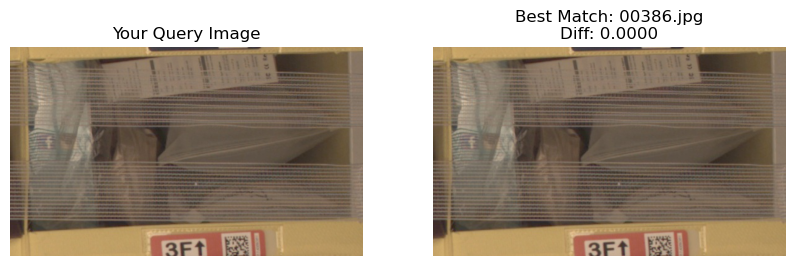


📋 VERIFIED INVENTORY (From Metadata):
- Item: Rover The Doodle Dog
  Quantity: 1
  ASIN: B00BFL68H2
------------------------------
- Item: Digesteeze Beefhide 8-inch Rolls- 3 pack (27818)
  Quantity: 1
  ASIN: B00FXPSOJG
------------------------------
- Item: ScanTool OBDLink MX Wi-Fi: OBD Adapter/Diagnostic Scanner for iOS, Android & Windows
  Quantity: 1
  ASIN: B00OCYXTYY
------------------------------
- Item: Running Belt, URPOWER® Multifunctional Zipper Pockets Water Resistant Waist Bag, Water Bottle (Two Bottles Included) Waist Pack for Running Hiking Cycling Climbing Camping Travel Compatible with iPhone 6S, 6, 5 5S 5C 4S,Samsung Galaxy S6 Edge,S6 S5 S4 S3 and Other Smartphones
  Quantity: 1
  ASIN: B00ZCEP9G4
------------------------------
- Item: Organic Wheatgrass Juice Powder - Raw & Non-GMO Wheatgrass Powder 454 Servings 226 g
  Quantity: 1
  ASIN: B017N5FDU6
------------------------------


In [9]:
import random

# 1. Pick a random image from our folder to pretend it's a "User Upload"
test_images = os.listdir("bin-images")
random_image = random.choice(test_images)
query_path = os.path.join("bin-images", random_image)

print(f"Testing with image: {query_path}")

# 2. Run the Search
system.search_and_display(query_path)